In [1]:
%pylab inline
%load_ext nb_black
import numpy as np
import requests, gzip, os, hashlib, numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import trange
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>

# Load

In [2]:
def fetch(url):

    fp = os.path.join("/home/wan268/tmp/", hashlib.md5(url.encode("utf-8")).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()


X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[
    0x10:
].reshape((-1, 28 * 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[
    0x10:
].reshape((-1, 28 * 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

<IPython.core.display.Javascript object>

(60000, 784)


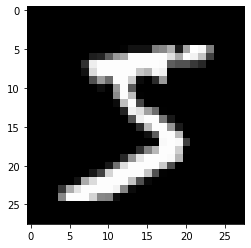

<IPython.core.display.Javascript object>

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(X_train[0].reshape((28, 28)), cmap="gray")
print(X_train.shape)

In [4]:
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()

<IPython.core.display.Javascript object>

In [5]:
n, c = X_train.shape[0], X_train.shape[1:]
print(X_train, Y_train)
print(X_train.shape)
print(Y_train.min(), Y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5., 0., 4.,  ..., 5., 6., 8.])
torch.Size([60000, 784])
tensor(0.) tensor(9.)


<IPython.core.display.Javascript object>

# Load v2

In [6]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

<IPython.core.display.Javascript object>

In [7]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((X_train, Y_train), (X_test, Y_test), _) = pickle.load(f, encoding="latin-1")

<IPython.core.display.Javascript object>

(50000, 784)


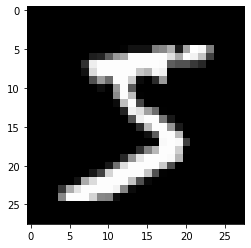

<IPython.core.display.Javascript object>

In [8]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(X_train[0].reshape((28, 28)), cmap="gray")
print(X_train.shape)

In [9]:
X_train, Y_train, X_test, Y_test = map(torch.tensor, (X_train, Y_train, X_test, Y_test))
n, c = X_train.shape

<IPython.core.display.Javascript object>

# torch.nn

In [10]:
# import math

# weights = torch.randn(784, 10, requires_grad=True) / math.sqrt(784)
# bias = torch.zeros(10, requires_grad=True)

<IPython.core.display.Javascript object>

In [11]:
import math

IMAGE_SIZE = 28 * 28
weights = torch.randn(IMAGE_SIZE, 10) / math.sqrt(IMAGE_SIZE)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

<IPython.core.display.Javascript object>

In [12]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)
    # return nn.LogSoftmax(x).dim


def model(xb):
    return log_softmax(xb @ weights + bias)

<IPython.core.display.Javascript object>

In [13]:
bs = 64  # batch size

xb = X_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions

print(preds)

tensor([[-2.3586, -2.6280, -2.4469, -2.2570, -1.9430, -2.4685, -1.9596, -2.3330,
         -2.6858, -2.2263],
        [-2.2372, -2.6757, -2.3691, -2.4288, -1.5569, -2.3473, -2.5315, -2.5454,
         -2.3159, -2.5307],
        [-2.2990, -2.4072, -2.6000, -2.2746, -2.3868, -2.1857, -2.7326, -2.5060,
         -2.0872, -1.8486],
        [-2.4735, -2.2307, -2.4771, -2.0749, -2.2266, -2.1607, -2.2193, -2.2825,
         -2.5207, -2.4717],
        [-2.0591, -2.0445, -2.5798, -2.0984, -2.6707, -2.2615, -2.2888, -2.5458,
         -2.4617, -2.2438],
        [-2.4587, -2.6739, -2.4281, -2.1513, -2.3926, -1.6751, -2.6044, -2.2556,
         -2.0362, -2.9383],
        [-2.6954, -2.5670, -2.4228, -2.4254, -2.3455, -2.2241, -1.7596, -2.4151,
         -2.4450, -2.0680],
        [-2.3595, -2.7625, -2.5301, -2.1954, -2.2775, -2.0206, -2.2137, -2.2994,
         -2.4143, -2.1432],
        [-2.4457, -2.4858, -2.4079, -2.3364, -2.4832, -2.0060, -1.9620, -2.4844,
         -2.2193, -2.3778],
        [-2.1028, -

<IPython.core.display.Javascript object>

In [14]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()


loss_func = nll

<IPython.core.display.Javascript object>

In [15]:
yb = Y_train[0:bs].long()
print(loss_func(preds, yb))

tensor(2.3119, grad_fn=<NegBackward>)


<IPython.core.display.Javascript object>

In [16]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

<IPython.core.display.Javascript object>

In [17]:
print(accuracy(preds, yb))

tensor(0.0312)


<IPython.core.display.Javascript object>

# Training loop

In [18]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in (t := trange(epochs, position=0)) :
    for i in trange((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = X_train[start_i:end_i]
        yb = Y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        cat = torch.argmax(pred, dim=1)
        acc = (cat == yb).float().mean()
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
        t.set_description("loss %.2f accuracy %.2f" % (loss, acc))

loss 0.32 accuracy 0.94: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


<IPython.core.display.Javascript object>

In [19]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0829, grad_fn=<NegBackward>) tensor(1.)


<IPython.core.display.Javascript object>

# Refactor 1

In [20]:
from torch import nn


class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

<IPython.core.display.Javascript object>

In [21]:
model = Mnist_Logistic()


<IPython.core.display.Javascript object>

In [22]:
print(loss_func(model(xb), yb))

tensor(-0.0444, grad_fn=<NegBackward>)


<IPython.core.display.Javascript object>

In [23]:
def fit():
    for epoch in trange(epochs):
        for i in trange((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = X_train[start_i:end_i]
            yb = Y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()


fit()

100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


<IPython.core.display.Javascript object>

In [24]:
print(loss_func(model(xb), yb))

tensor(-3578.5322, grad_fn=<NegBackward>)


<IPython.core.display.Javascript object>

# Refactor 2

In [25]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 10)

    def forward(self, xb):
        xb = self.l1(xb)
        xb = self.l2(xb)
        return xb

<IPython.core.display.Javascript object>

In [26]:
# Hyper
device = torch.device("cuda:1")
model = Mnist_Logistic().to(device)
EPOCHS = 20
LR = 0.001
BS = 128
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)
losses, accuracies, = [], []
train_ds = TensorDataset(X_train.to(device), Y_train.to(device))
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True)
test_ds = TensorDataset(X_test.to(device), Y_test.to(device))
test_dl = DataLoader(test_ds, batch_size=BS * 2)

<IPython.core.display.Javascript object>

In [27]:
# Loop
for epoch in (t := trange(EPOCHS)):
    for xb, yb in train_dl:
        
        optimizer.zero_grad()
        pred = model(xb)
        cat = torch.argmax(pred, dim=1)
        acc = (cat == yb).float().mean()
        loss = loss_function(pred, yb)
        loss.backward()
        optimizer.step()
        
        loss, acc = (loss.item(), acc.item())
        losses.append(loss)
        accuracies.append(acc)
        
        t.set_description(
        "loss %.2f accuracy %.2f"
        % (loss, acc)
        )
        


loss 0.61 accuracy 0.89: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


<IPython.core.display.Javascript object>

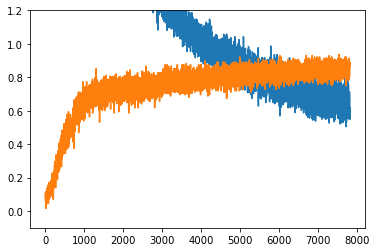

<IPython.core.display.Javascript object>

In [28]:
plt.ylim(-0.1, 1.2)
plot(losses)
plot(accuracies)

In [29]:
preds = model.to("cpu")(X_test).float()
Y_test_preds = torch.argmax(preds, dim=1)
(Y_test == Y_test_preds).numpy().mean()

0.8669

<IPython.core.display.Javascript object>

# CNN

In [99]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.max_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

<IPython.core.display.Javascript object>

In [100]:
# Hyper
device = torch.device("cuda:1")
model = Mnist_Logistic().to(device)
EPOCHS = 40
LR = 0.1
BS = 512
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
losses, accuracies, = [], []
train_ds = TensorDataset(X_train.to(device), Y_train.to(device))
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True)
test_ds = TensorDataset(X_test.to(device), Y_test.to(device))
test_dl = DataLoader(test_ds, batch_size=BS * 2)

<IPython.core.display.Javascript object>

In [101]:
# Loop
for epoch in (t := trange(EPOCHS)):
    for xb, yb in train_dl:
        
        optimizer.zero_grad()
        pred = model(xb)
        cat = torch.argmax(pred, dim=1)
        acc = (cat == yb).float().mean()
        loss = loss_function(pred, yb)
        loss.backward()
        optimizer.step()
        
        loss, acc = (loss.item(), acc.item())
        losses.append(loss)
        accuracies.append(acc)
        
        t.set_description(
        "loss %.2f accuracy %.2f"
        % (loss, acc)
        )
        


loss 0.08 accuracy 0.98: 100%|██████████| 40/40 [00:22<00:00,  1.80it/s]


<IPython.core.display.Javascript object>

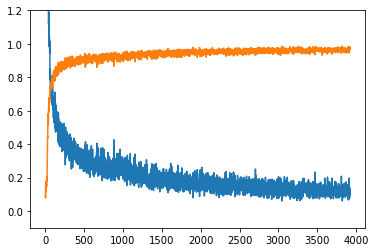

<IPython.core.display.Javascript object>

In [104]:
plt.ylim(-0.1, 1.2)
plot(losses)
plot(accuracies)

In [105]:
preds = model.to("cpu")(X_test).float()
Y_test_preds = torch.argmax(preds, dim=1)
(Y_test == Y_test_preds).numpy().mean()

0.9537

<IPython.core.display.Javascript object>